<a href="https://colab.research.google.com/github/condehub5/Trabajo-Final---Universidad-del-Pac-fico/blob/main/Trabajo_Final_Estimaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐟 Proyecto Final: Pronóstico de la Demanda de Pesca para Consumo Interno Nacional en el Perú (1991–2023)

Este proyecto tiene como objetivo estimar y proyectar la **demanda mensual de pesca destinada al consumo interno nacional** en el Perú, utilizando datos oficiales proporcionados por el **Instituto Nacional de Estadística e Informática (INEI)**. La serie abarca desde enero de 1991 hasta diciembre de 2023 y representa una variable relevante para el análisis sectorial de alimentos, producción primaria y consumo nacional.

En contextos de inflación, incertidumbre y volatilidad, contar con modelos de pronóstico confiables permite a entidades públicas, empresas pesqueras y actores de la cadena alimentaria anticipar fluctuaciones en la oferta y la demanda, y planificar de forma estratégica.

El análisis incluirá:

- Visualización exploratoria de la serie histórica.
- Aplicación de al menos tres modelos distintos para pronóstico:
  - **ARIMA:** Modelo estadístico tradicional para series temporales.
  - **Prophet:** Modelo aditivo desarrollado por Meta, adecuado para estacionalidad y tendencias.
  - **Random Forest Regressor:** Algoritmo de Machine Learning no paramétrico que aprovecha variables temporales como mes y año.

Los modelos serán evaluados en un periodo de prueba fuera de muestra mediante métricas como **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)**. Finalmente, se realizará una interpretación financiera y estratégica de los resultados obtenidos.

---

In [5]:
import numpy as np
import pandas as pd #SIRVE PARA DATAFRAMES
import matplotlib.pyplot as plt #sirve para gráficos
import seaborn as sns #graficos al interior de matplotlib
from statsmodels.tsa.holtwinters import ExponentialSmoothing #para trabajar modelos de econometria

In [2]:
dir()

['ExponentialSmoothing',
 'In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'np',
 'pd',
 'plt',
 'quit',
 'sns']

🟦 SNIPPET 1 – Cargar el archivo Excel desde INEI

In [33]:
# 📂 Cargar archivo Excel con series pesqueras del INEI

# Ruta del archivo (debe estar en el mismo directorio o haber sido subido en Colab)
file_path = "Series INEI pesca.xlsx"

# Leer el archivo completo sin encabezados
xls = pd.ExcelFile(file_path)
df_full = xls.parse(xls.sheet_names[0], header=None)

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


       fecha                                           variable  \
0 1996-01-01  Consumo humano directo de productos pesquero:C...   
1 1997-01-01  Consumo humano directo de productos pesquero:C...   
2 1998-01-01  Consumo humano directo de productos pesquero:C...   
3 1999-01-01  Consumo humano directo de productos pesquero:C...   
4 2000-01-01  Consumo humano directo de productos pesquero:C...   

                               unidad  valor  
0  Miles de toneladas métricas brutas   64.0  
1  Miles de toneladas métricas brutas   39.1  
2  Miles de toneladas métricas brutas   24.6  
3  Miles de toneladas métricas brutas   24.8  
4  Miles de toneladas métricas brutas   30.5  


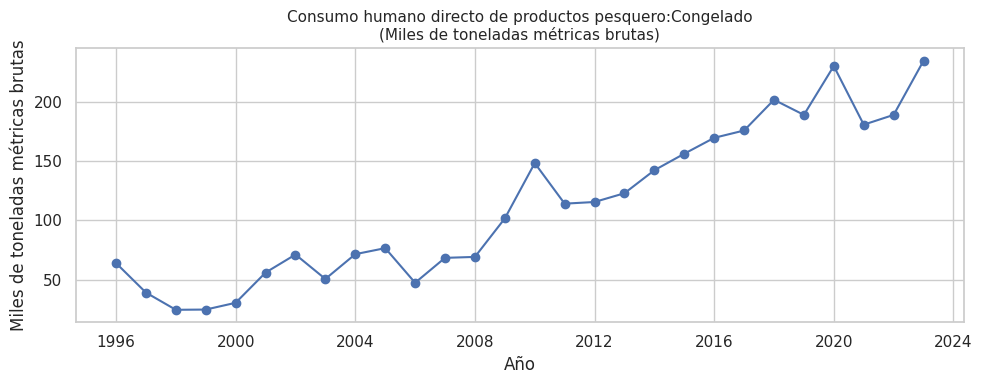

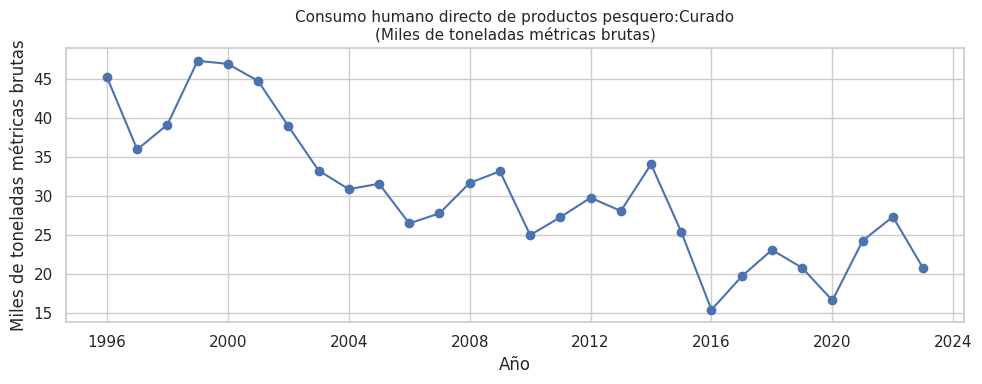

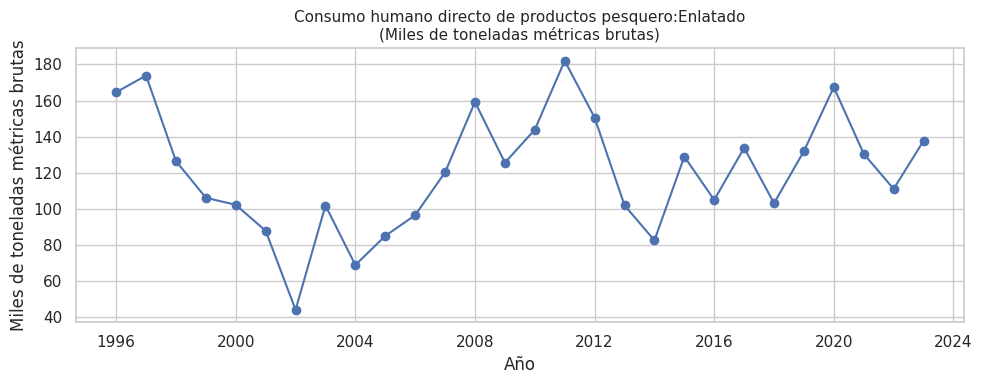

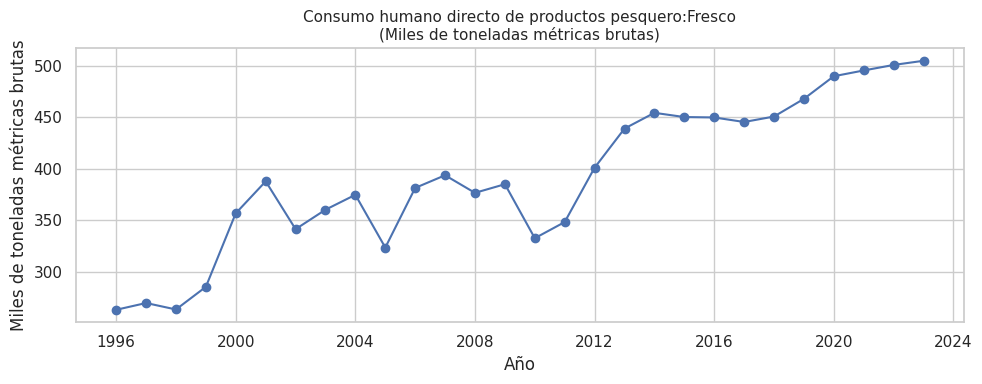

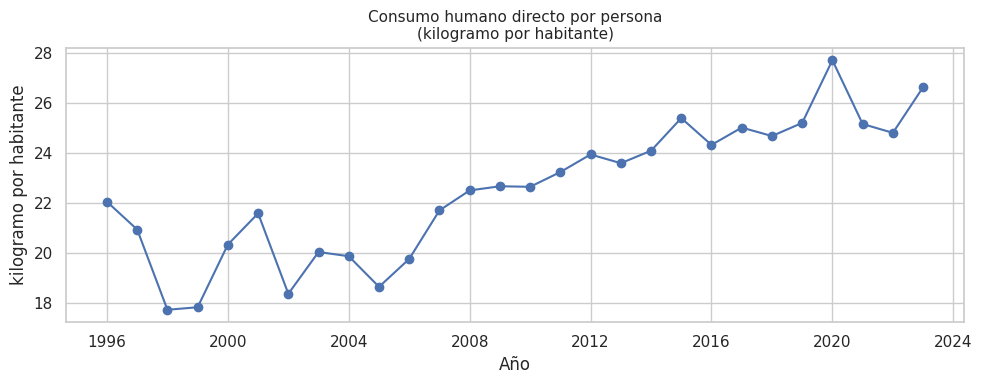

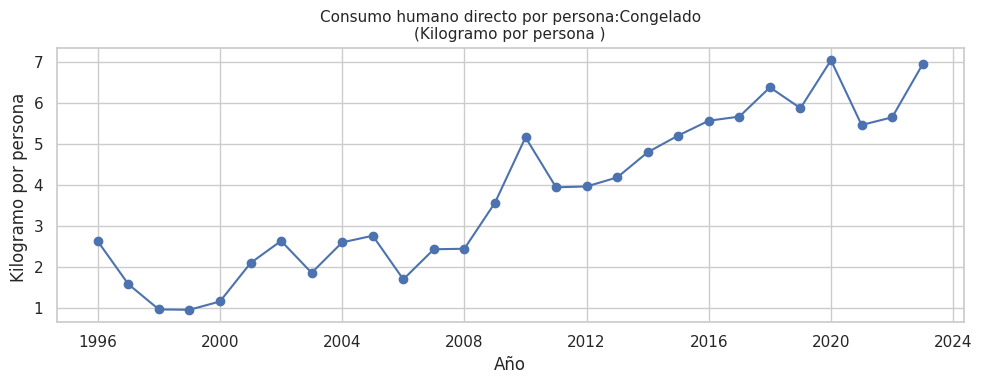

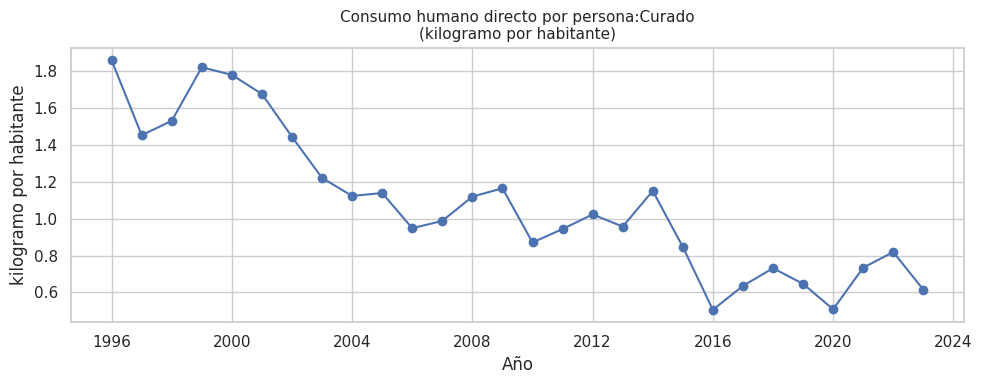

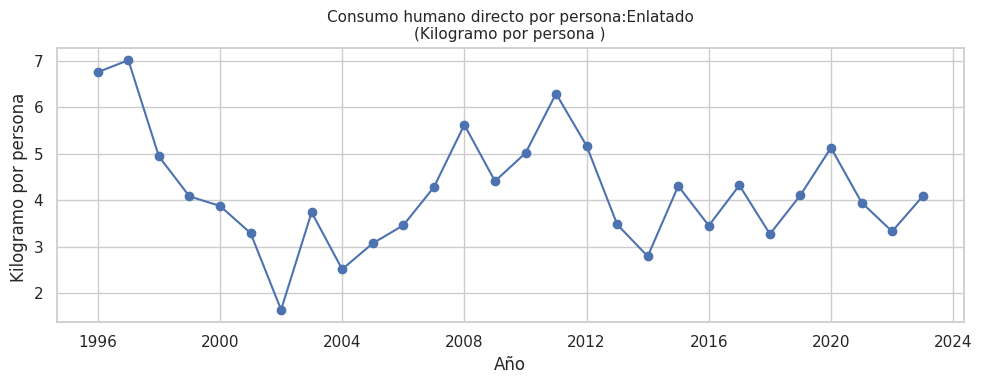

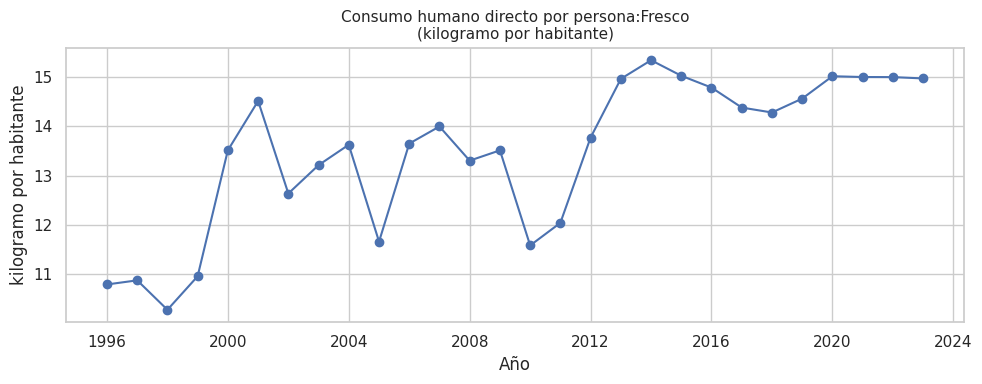

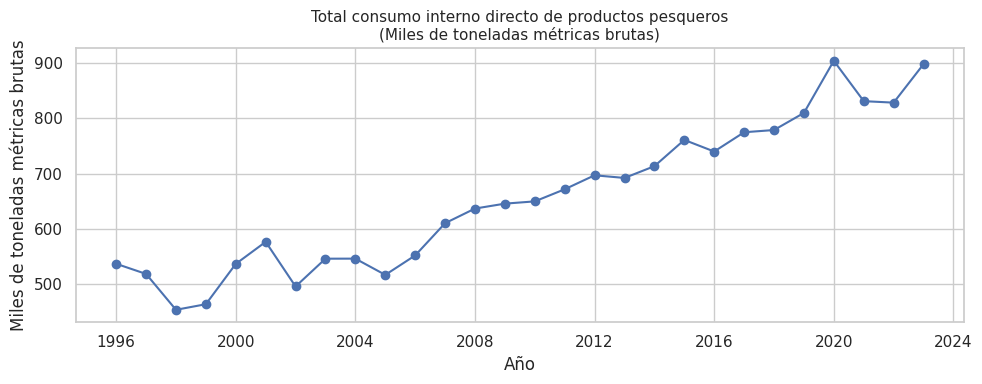

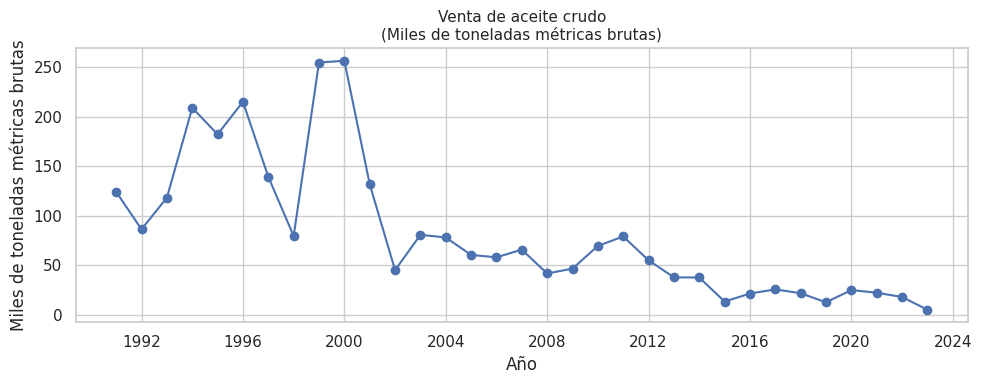

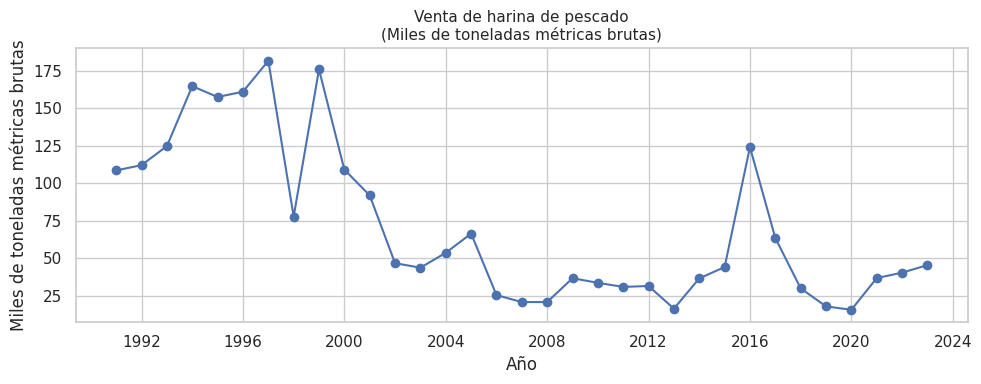

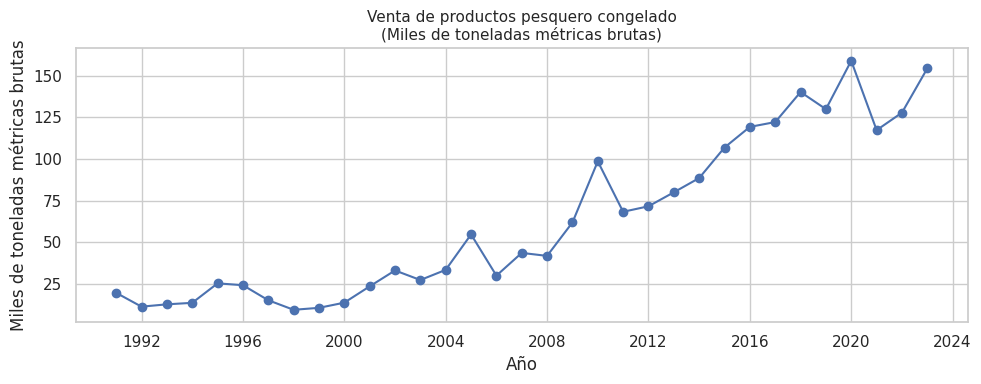

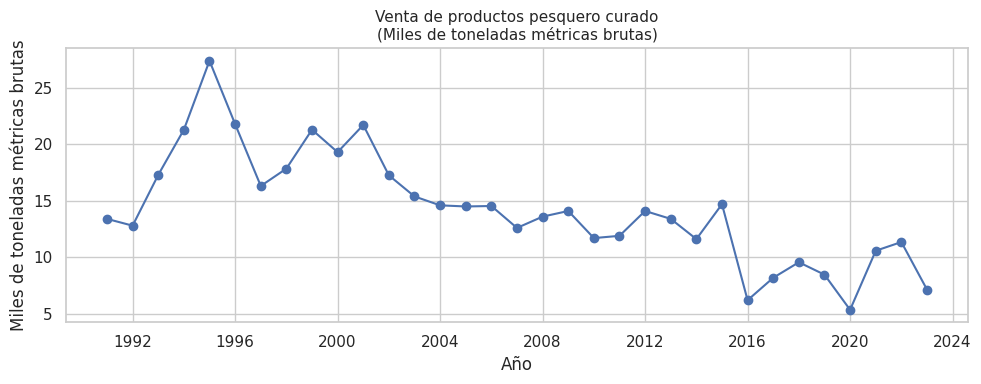

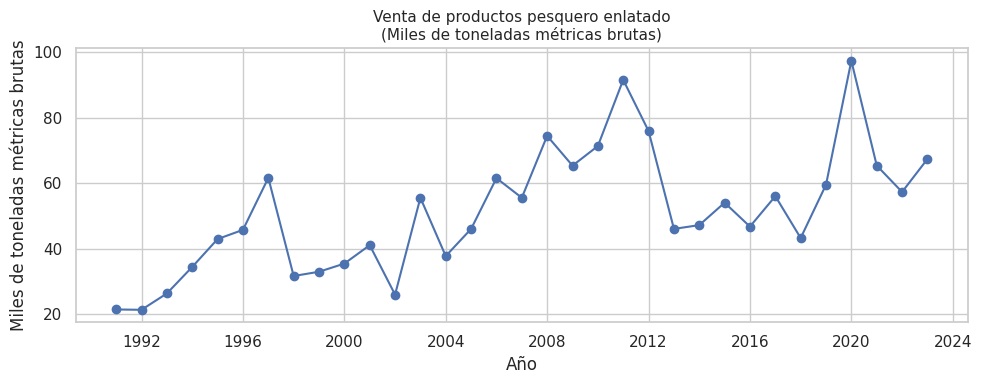

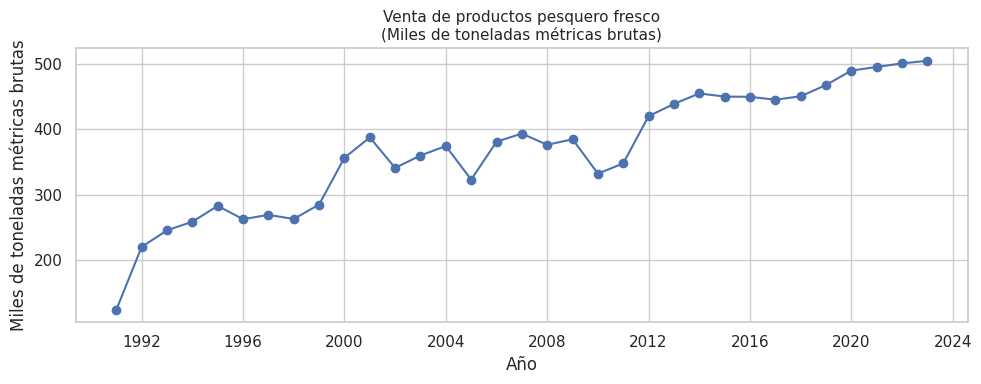

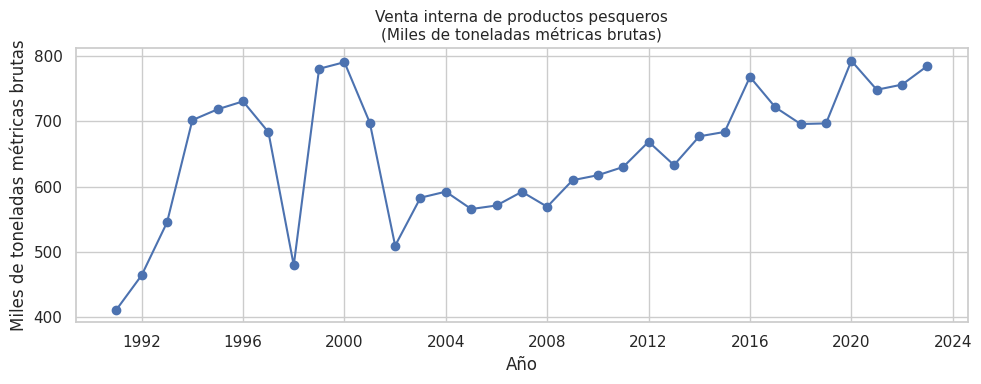

In [34]:
# 🏷️ Paso 2: Extraer los nombres de las variables
# Los nombres están en la columna B (índice 1), desde la fila 4 a la 21 (índices 4 a 21)
nombres_series = df_full.iloc[4:22, 1].values     # B4:B21

# 📐 Paso 3: Extraer las unidades de cada variable
# Están en la columna C (índice 2), mismas filas
unidades_series = df_full.iloc[4:22, 2].values    # C4:C21

# 📅 Paso 4: Extraer los años (encabezados de columnas de datos)
# Están en la fila 3 (índice 2), columnas D a AJ (índices 3 a 35)
anios = df_full.iloc[2, 3:36].values              # D3:AJ3

# 📈 Paso 5: Extraer los valores por serie
# Cada fila contiene una serie horizontal distinta, desde la columna D a AJ
valores_series = df_full.iloc[4:22, 3:36].values  # D4:AJ21

# 🔄 Paso 6: Transformar todo a formato vertical (long format)
records = []  # Lista para almacenar filas

# Iterar sobre cada variable/serie
for i in range(len(nombres_series)):
    nombre = nombres_series[i]      # Nombre de la serie
    unidad = unidades_series[i]     # Unidad correspondiente
    valores = valores_series[i]     # Valores de la serie horizontal

    # Iterar por cada año y su valor
    for anio, valor in zip(anios, valores):
        try:
            fecha = pd.to_datetime(f"{int(anio)}-01-01")  # Crear fecha desde año
            if pd.notna(valor):  # Incluir solo si es un número válido
                records.append({
                    'fecha': fecha,
                    'variable': nombre,
                    'unidad': unidad,
                    'valor': float(valor)
                })
        except:
            continue  # Saltar valores no válidos

# 🧱 Paso 7: Crear DataFrame final en formato vertical
df_series_completo = pd.DataFrame(records)  # Crear DataFrame desde registros
df_series_completo = df_series_completo.sort_values(['variable', 'fecha']).reset_index(drop=True)

# 👁️ Paso 8: Vista previa del DataFrame
print(df_series_completo.head())  # Mostrar primeras filas

# 📊 Paso 9: Graficar todas las series individualmente con sus unidades
sns.set(style="whitegrid")  # Estilo visual

# Iterar sobre cada variable única y generar un gráfico
for var in df_series_completo['variable'].unique():
    df_temp = df_series_completo[df_series_completo['variable'] == var]  # Filtrar serie
    unidad = df_temp['unidad'].iloc[0]  # Obtener unidad asociada

    # Crear gráfico de línea
    plt.figure(figsize=(10, 4))
    plt.plot(df_temp['fecha'], df_temp['valor'], marker='o')
    plt.title(f"{var}\n({unidad})", fontsize=11)
    plt.xlabel("Año")
    plt.ylabel(unidad)
    plt.grid(True)
    plt.tight_layout()
    plt.show()